In [2]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

- number of cores, set this number according to your computer

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

- sample product, you can change to your specific product symbol

In [5]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [4]:
import dask
from dask import compute, delayed

- get the list of this form

In [5]:
all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
n_days = len(all_dates)
n_days
## 915

915

- number of days

In [7]:
all_dates[:6]
# ['20151202.pkl',
#  '20151203.pkl',
#  '20151204.pkl',
#  '20151207.pkl',
#  '20151208.pkl',
#  '20151209.pkl']

['20151202.pkl',
 '20151203.pkl',
 '20151204.pkl',
 '20151207.pkl',
 '20151208.pkl',
 '20151209.pkl']

- some days may have error because of rolling contracts

- we randomly choose a day

In [8]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])

- plot all the data

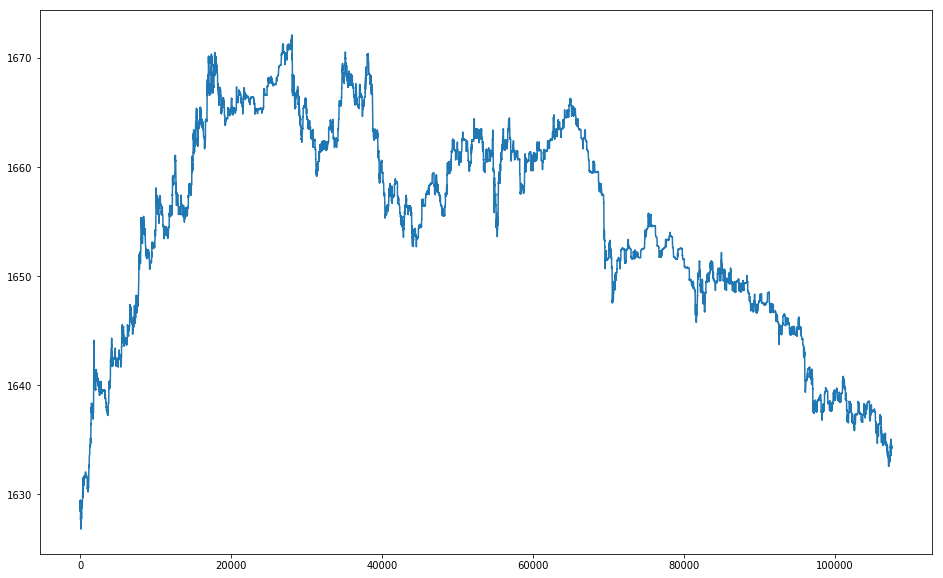

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- Welcome to Quantitative and High Frequency Trading Training Program


- plot the data to be used in red

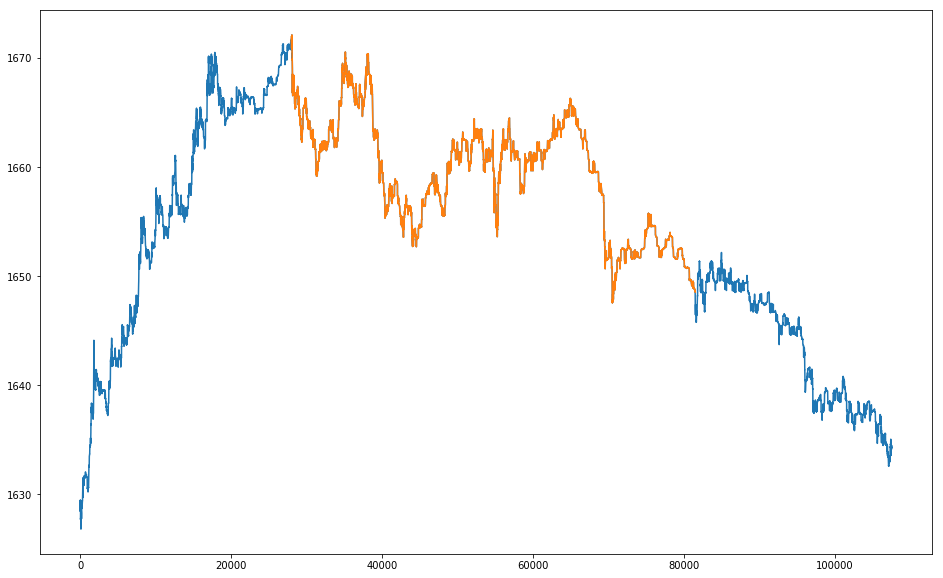

In [13]:
plt.figure(1, figsize=(16, 10))
plt.plot(data.reset_index()["wpr"]);
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

- number of usable points

In [14]:
sum(data["good"])
## 53476

53476

- total number of two days

In [15]:
len(data)
## 107533

107533

- so we only use the middle part of the data


- test the first predictive signal
- we can use look-back period of 4096 at first

In [16]:
period = 4096

- the first signal is the buy/sell imbalance signal


- create directory for all signals

- create directory for the product

In [15]:
import os
for product in product_list:
    os.makedirs(HEAD_PATH + "/tmp pkl/" + product, exist_ok=True)

- create directory for the signal

In [16]:
for product in product_list:
    os.makedirs(HEAD_PATH + "/tmp pkl/" + product + "/trade.imb." + str(period), exist_ok=True)

- now let's check the signal


- it's the buy/sell imbalance of one tick

- zero_divide is zero when denominator is zero
- we can see the definition of zero_divide in helper.py


- returns 0 if the numerator or denominator is 0

In [10]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

In [14]:
class foctor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

In [15]:
x1 = foctor_total_trade_imb_period()
for product in product_list:
    create_signal_path(x1, product, HEAD_PATH);

d:/intern/tmp pkl/rb/total.trade.imb.1024
d:/intern/tmp pkl/rb/total.trade.imb.2048
d:/intern/tmp pkl/rb/total.trade.imb.4096
d:/intern/tmp pkl/hc/total.trade.imb.1024
d:/intern/tmp pkl/hc/total.trade.imb.2048
d:/intern/tmp pkl/hc/total.trade.imb.4096
d:/intern/tmp pkl/i/total.trade.imb.1024
d:/intern/tmp pkl/i/total.trade.imb.2048
d:/intern/tmp pkl/i/total.trade.imb.4096
d:/intern/tmp pkl/j/total.trade.imb.1024
d:/intern/tmp pkl/j/total.trade.imb.2048
d:/intern/tmp pkl/j/total.trade.imb.4096
d:/intern/tmp pkl/jm/total.trade.imb.1024
d:/intern/tmp pkl/jm/total.trade.imb.2048
d:/intern/tmp pkl/jm/total.trade.imb.4096


In [22]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x1, product=product, HEAD_PATH=HEAD_PATH)
;
# Wall time: 15min 10s


Wall time: 15min 10s


- we can check the result

- we can see that they are the same
- so the signal calculation process is correct


- now calcualte all the value of this signal

In [14]:
import statsmodels.tsa.stattools as ts
import math

In [24]:
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "total.trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)
# rb adf (-8.951185892502407, 4.680399280573336e-13, 9, 942, {'1%': -3.9684127065049677, '5%': -3.415160959119063, '10%': -3.1297992482881454})
# rb kpss (0.07046361664712475, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# hc adf (-7.504883513735666, 9.931223692186425e-10, 9, 774, {'1%': -3.9705142540293275, '5%': -3.416177532504622, '10%': -3.130397168497367})
# hc kpss (0.13469561329645657, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# i adf (-8.727627322319103, 1.5095488301374686e-12, 9, 856, {'1%': -3.969385062345962, '5%': -3.415631376166872, '10%': -3.1300759530647597})
# i kpss (0.11415060690599653, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# j adf (-7.8353943609924865, 1.716090260164704e-10, 8, 676, {'1%': -3.9722248029965295, '5%': -3.417004594904988, '10%': -3.1308835135904487})
# j kpss (0.2554963571713695, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# jm adf (-6.753300534637084, 5.0682954532948184e-08, 8, 598, {'1%': -3.973989086306263, '5%': -3.417857286373346, '10%': -3.131384826301577})
# jm kpss (0.18754249637046824, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

rb adf (-8.951185892502401, 4.680399280573507e-13, 9, 942, {'1%': -3.9684127065049677, '5%': -3.415160959119063, '10%': -3.1297992482881454})
rb kpss (0.07046361664712467, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


hc adf (-7.504883513735659, 9.93122369218679e-10, 9, 774, {'1%': -3.9705142540293275, '5%': -3.416177532504622, '10%': -3.130397168497367})
hc kpss (0.13469561329645652, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


i adf (-8.727627322319117, 1.5095488301373487e-12, 9, 856, {'1%': -3.969385062345962, '5%': -3.415631376166872, '10%': -3.1300759530647597})
i kpss (0.1141506069059965, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


j adf (-7.835394360992178, 1.7160902601675202e-10, 8, 676, {'1%': -3.9722248029965295, '5%': -3.417004594904988, '10%': -3.1308835135904487})
j kpss (0.25549635717136954, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


jm adf (-6.753300534637072, 5.0682954532950996e-08, 8, 598, {'1%': -3.973989086306263, '5%': -3.417857286373346, '10%': -3.131384826301577})
jm kpss (0.18754249637046821, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


- for adf, if p-valus(the second one) is small, then it's stationary;
- for kpss, if p-value is large, then it's stationary;
- so for trade.imb.4096, all of them are stationary
- now we calcualte another signal which measures the range ranther than direciton

In [89]:
class foctor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values

In [91]:
x4 = foctor_trade_imb_period()
for product in product_list:
    create_signal_path(x4, product, HEAD_PATH);

d:/intern/tmp pkl/rb/trade.imb.1024
d:/intern/tmp pkl/rb/trade.imb.2048
d:/intern/tmp pkl/rb/trade.imb.4096
d:/intern/tmp pkl/hc/trade.imb.1024
d:/intern/tmp pkl/hc/trade.imb.2048
d:/intern/tmp pkl/hc/trade.imb.4096
d:/intern/tmp pkl/i/trade.imb.1024
d:/intern/tmp pkl/i/trade.imb.2048
d:/intern/tmp pkl/i/trade.imb.4096
d:/intern/tmp pkl/j/trade.imb.1024
d:/intern/tmp pkl/j/trade.imb.2048
d:/intern/tmp pkl/j/trade.imb.4096
d:/intern/tmp pkl/jm/trade.imb.1024
d:/intern/tmp pkl/jm/trade.imb.2048
d:/intern/tmp pkl/jm/trade.imb.4096


In [92]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4, product=product, HEAD_PATH=HEAD_PATH)
# Wall time: 5min 47s

Wall time: 5min 47s


In [15]:
period = 4096
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)

# rb adf (-8.644150194359936, 2.342844640721285e-12, 9, 942, {'1%': -3.9684127065049677, '5%': -3.415160959119063, '10%': -3.1297992482881454})
# rb kpss (0.2761519226136357, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
#   warn("p-value is greater than the indicated p-value", InterpolationWarning)

# hc adf (-8.036580774225861, 5.880743373799121e-11, 9, 774, {'1%': -3.9705142540293275, '5%': -3.416177532504622, '10%': -3.130397168497367})
# hc kpss (0.7159435157741604, 0.012096044020530874, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# i adf (-7.820660738609837, 1.8560499839831788e-10, 9, 856, {'1%': -3.969385062345962, '5%': -3.415631376166872, '10%': -3.1300759530647597})
# i kpss (0.2688375536676349, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
#   warn("p-value is greater than the indicated p-value", InterpolationWarning)

# j adf (-8.344476454773995, 1.1439906130440358e-11, 8, 676, {'1%': -3.9722248029965295, '5%': -3.417004594904988, '10%': -3.1308835135904487})
# j kpss (0.1187409216754323, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
#   warn("p-value is greater than the indicated p-value", InterpolationWarning)

# jm adf (-6.965824864504407, 1.6881177440341636e-08, 8, 598, {'1%': -3.973989086306263, '5%': -3.417857286373346, '10%': -3.131384826301577})
# jm kpss (0.2512368011324609, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

# d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
#   warn("p-value is greater than the indicated p-value", InterpolationWarning)



rb adf (-8.644150194359936, 2.342844640721285e-12, 9, 942, {'1%': -3.9684127065049677, '5%': -3.415160959119063, '10%': -3.1297992482881454})
rb kpss (0.2761519226136357, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


hc adf (-8.036580774225861, 5.880743373799121e-11, 9, 774, {'1%': -3.9705142540293275, '5%': -3.416177532504622, '10%': -3.130397168497367})
hc kpss (0.7159435157741604, 0.012096044020530874, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
i adf (-7.820660738609837, 1.8560499839831788e-10, 9, 856, {'1%': -3.969385062345962, '5%': -3.415631376166872, '10%': -3.1300759530647597})
i kpss (0.2688375536676349, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


j adf (-8.344476454773995, 1.1439906130440358e-11, 8, 676, {'1%': -3.9722248029965295, '5%': -3.417004594904988, '10%': -3.1308835135904487})
j kpss (0.1187409216754323, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


jm adf (-6.965824864504407, 1.6881177440341636e-08, 8, 598, {'1%': -3.973989086306263, '5%': -3.417857286373346, '10%': -3.131384826301577})
jm kpss (0.2512368011324609, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [34]:
def get_atr(file, product, period_list, spread):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, HEAD_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])


In [36]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13)), spread=spread) 


Wall time: 4min 8s


- It measures how many bid/ask spreads of range in the previous period 
- In this case, we can measure volatility of each product in similar criteron
- because slippage is the largest cost for intraday trading

In [3]:
class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period, spread):
        atr = (data["max."+str(period)]-data["min."+str(period)])/spread
        return atr

In [6]:
x2 = foctor_atr_period()
for product in product_list:
    create_signal_path(x2, product, HEAD_PATH);

d:/intern/tmp pkl/rb/atr.1024
d:/intern/tmp pkl/rb/atr.2048
d:/intern/tmp pkl/rb/atr.4096
d:/intern/tmp pkl/hc/atr.1024
d:/intern/tmp pkl/hc/atr.2048
d:/intern/tmp pkl/hc/atr.4096
d:/intern/tmp pkl/i/atr.1024
d:/intern/tmp pkl/i/atr.2048
d:/intern/tmp pkl/i/atr.4096
d:/intern/tmp pkl/j/atr.1024
d:/intern/tmp pkl/j/atr.2048
d:/intern/tmp pkl/j/atr.4096
d:/intern/tmp pkl/jm/atr.1024
d:/intern/tmp pkl/jm/atr.2048
d:/intern/tmp pkl/jm/atr.4096


In [ ]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    spread = product_info[product]["spread"]
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x2, product=product, HEAD_PATH=HEAD_PATH)

- Then we can modify our backtest program to include a trend signal and a range signal

In [23]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                   HEAD_PATH="d:/intern", atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    pred = pred[data["good"]]
    atr = load(HEAD_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0)]), index=thre_mat.index)
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            avg_pnl = 0
            final_pnl = 0
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
    return result

- First we want to know the range of signal

In [45]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "total.trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

- we can plot the range together in one graph

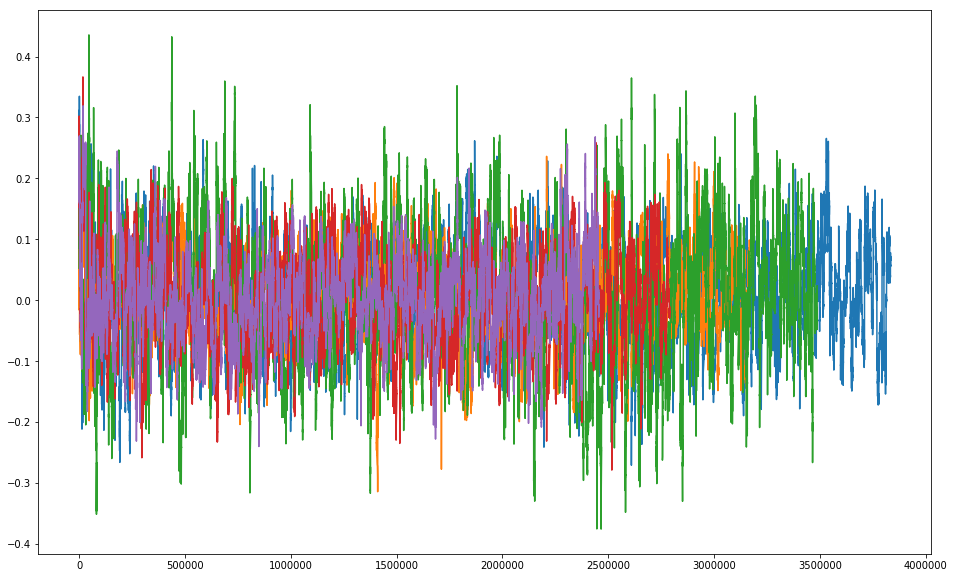

In [46]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

In [6]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

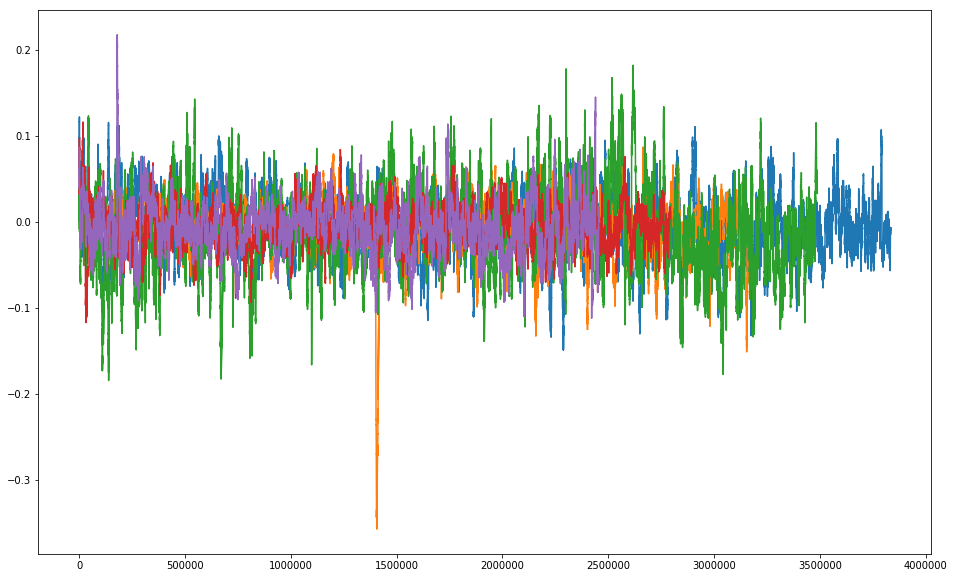

In [7]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

In [13]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.088, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat

,open,close
0,0.05,-0.010
1,0.05,-0.020
2,0.05,-0.030
3,0.05,-0.040
4,0.05,-0.050
5,0.06,-0.012
6,0.06,-0.024
7,0.06,-0.036
8,0.06,-0.048
9,0.06,-0.060


- then at the quantile values

In [28]:
%%time
signal_name = "trade.imb.4096"
all_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

#Wall time: 12min 38s


Wall time: 12min 38s


In [29]:
save(all_trade_stat, HEAD_PATH+"/"+"all_trade_stat_trade_imb_4096.pkl")

- it seems the signal value leans to negative

- for example we care about the average pnl

In [9]:
all_trade_stat = load(HEAD_PATH+"/"+"all_trade_stat_trade_imb_4096.pkl")
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

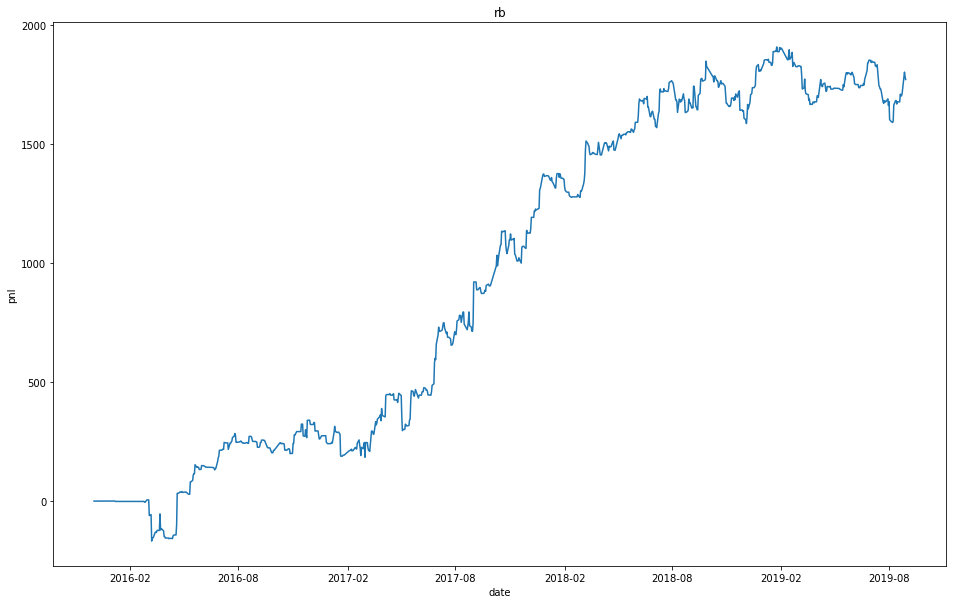

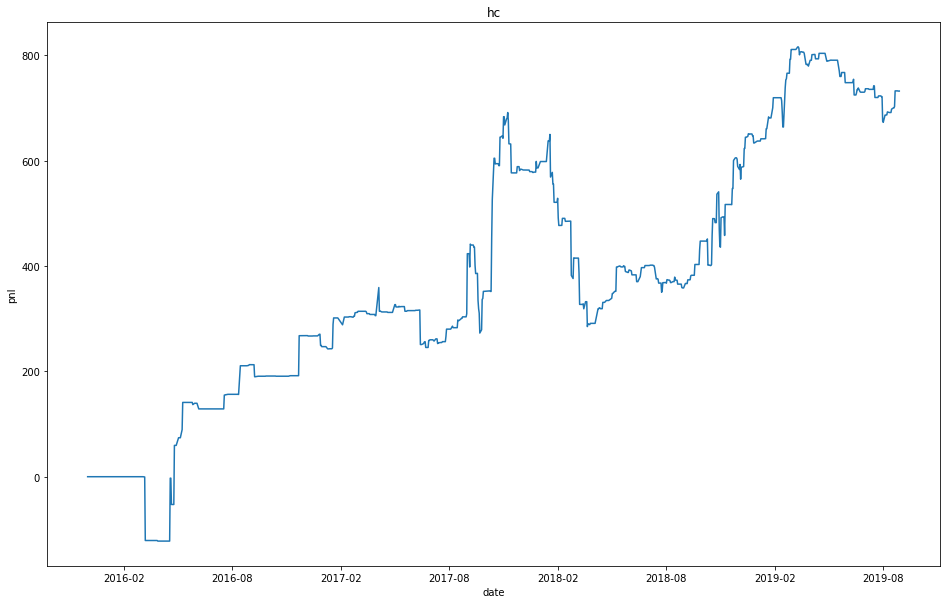

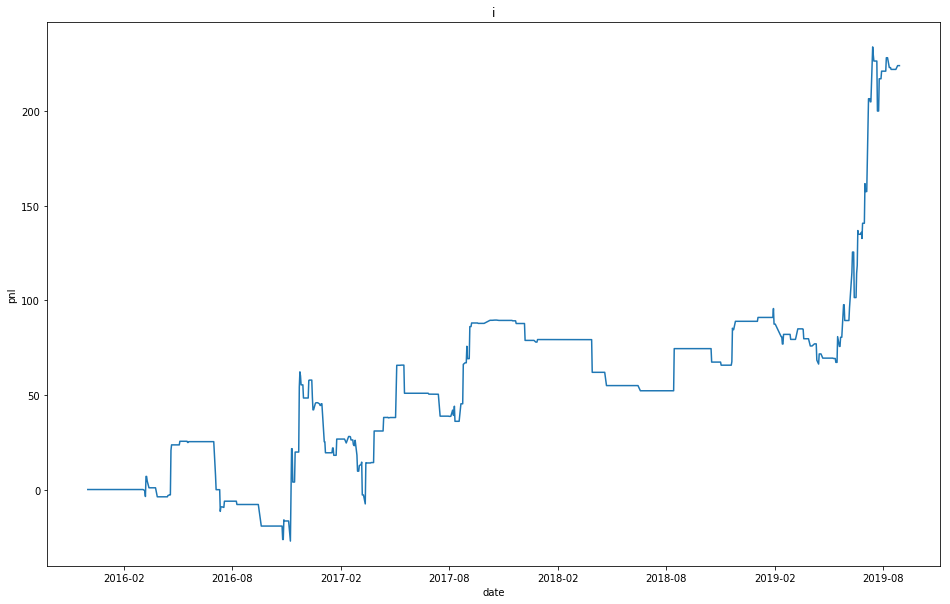

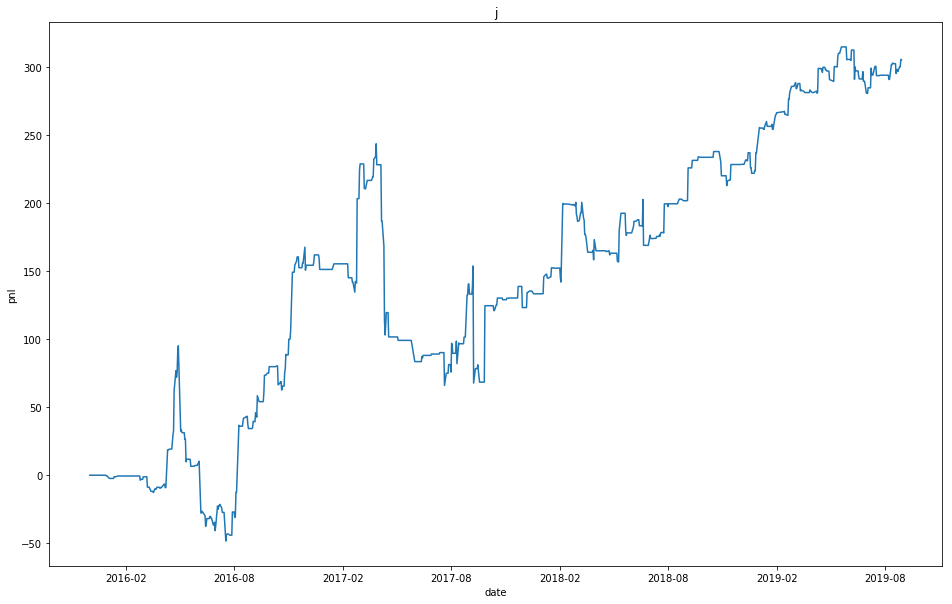

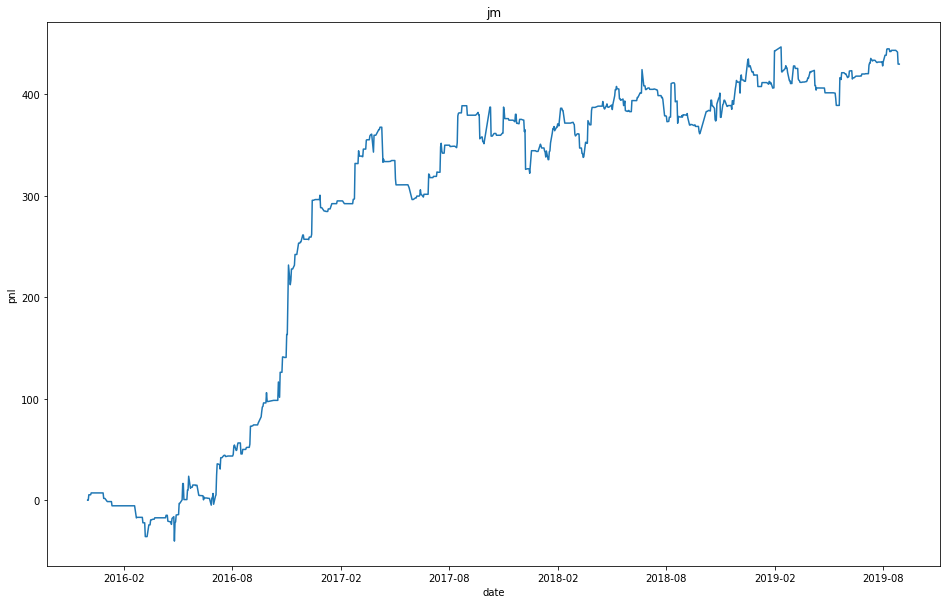

In [10]:
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

- get training samples

In [12]:
product = "rb"
spread = product_info[product]["spread"]
trade_stat = all_trade_stat[product]
good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
trade_stat["final.result"]

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.050,-0.0100,945,1.485651,1403.94027,0.713448,400.84343,640.72053,2.191190
1,0.050,-0.0200,917,1.591038,1458.98217,0.713667,385.04336,605.60433,2.409134
2,0.050,-0.0300,897,1.739539,1560.36677,0.715112,445.94608,689.21847,2.263965
3,0.050,-0.0400,880,1.597219,1405.55247,0.609666,494.08533,860.43519,1.633537
4,0.050,-0.0500,865,1.515027,1310.49836,0.555446,486.74035,801.71513,1.634618
5,0.052,-0.0104,886,1.719849,1523.78627,0.793241,469.84256,706.71889,2.156142
6,0.052,-0.0208,863,2.278419,1966.27528,0.973372,441.03974,655.91519,2.997758
7,0.052,-0.0312,842,2.227745,1875.76131,0.881268,475.88537,687.03101,2.730243
8,0.052,-0.0416,828,2.190256,1813.53196,0.799888,519.44271,701.59000,2.584889
9,0.052,-0.0520,815,2.263979,1845.14267,0.795385,522.02719,760.17426,2.427263


In [41]:
train_sample = np.array(all_dates)<"2018"

- now let's see the in-sample and out-of-sample performance


- the previous result used the whole data set 
- so it may be more optimistic than reality
- now we split the data into training sample and test sample


- at first let's remain 2018 as out-of-sample

- number of training samples

In [42]:
sum(train_sample)
## 510

510

- get testing samples

In [43]:
test_sample = np.array(all_dates)>"2018"
sum(test_sample)
## 405

405

In [90]:
%%time
signal_name = "trade.imb.4096"
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
# Wall time: 7min 15s

Wall time: 7min 15s


In [49]:
save(train_trade_stat, HEAD_PATH+"/train_trade_stat.pkl")

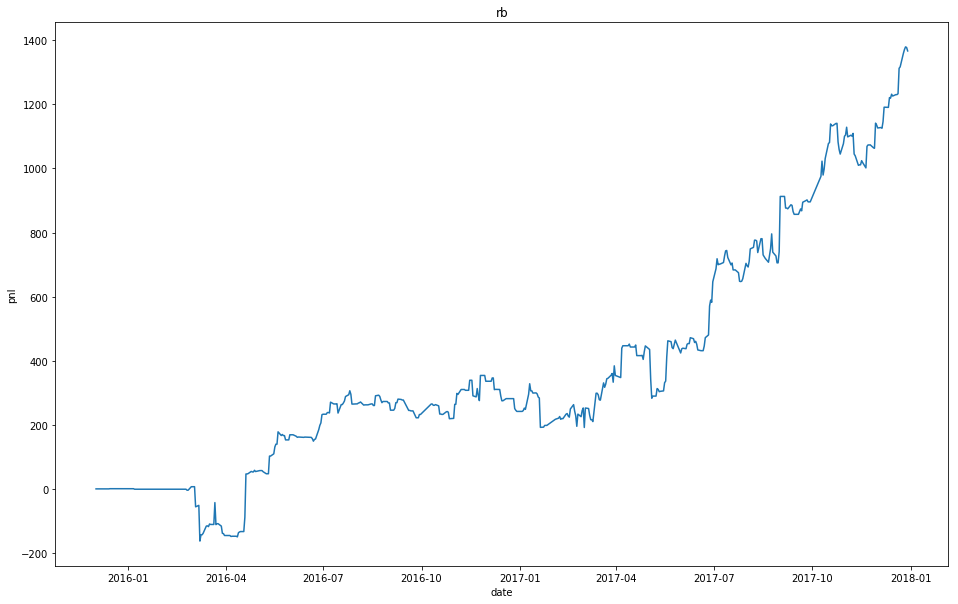

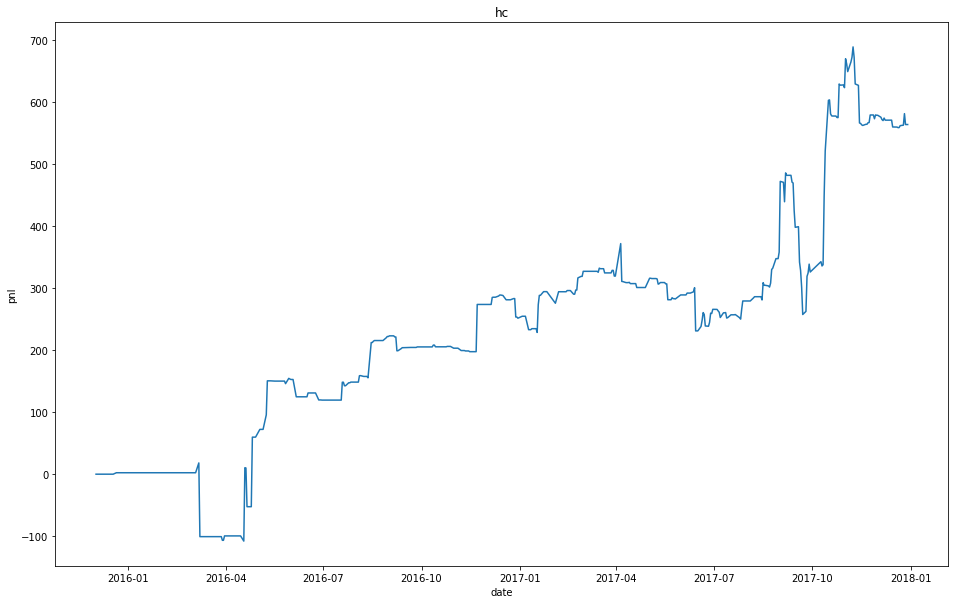

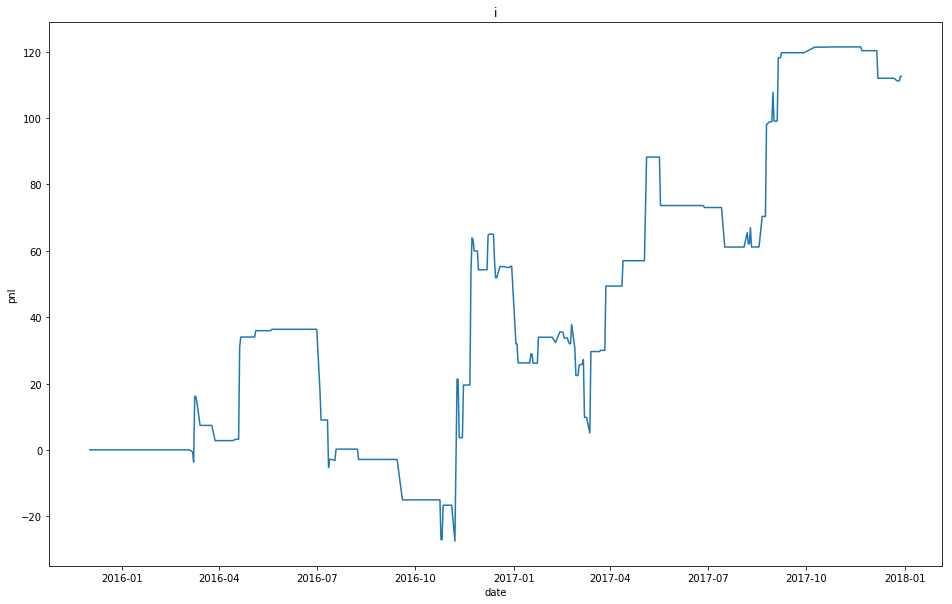

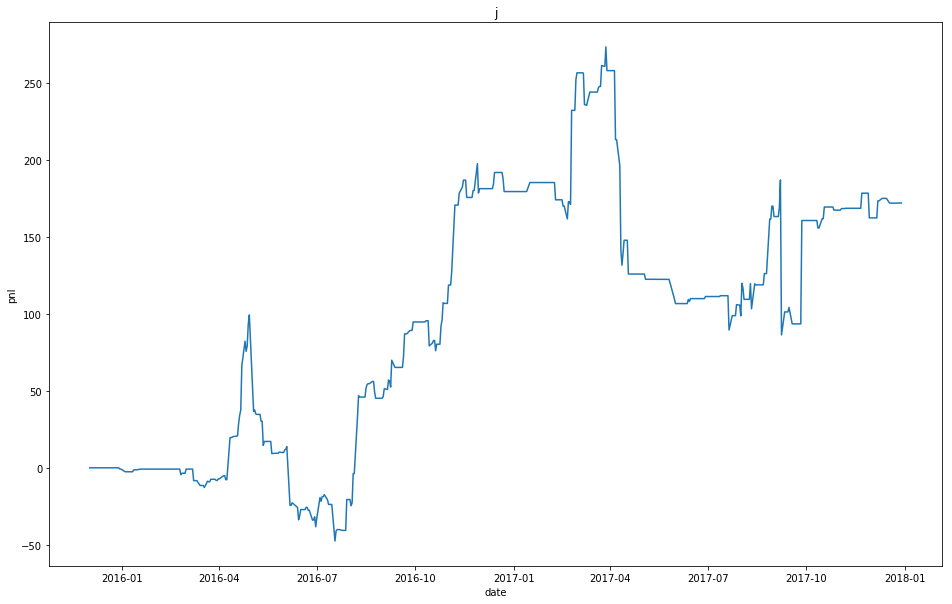

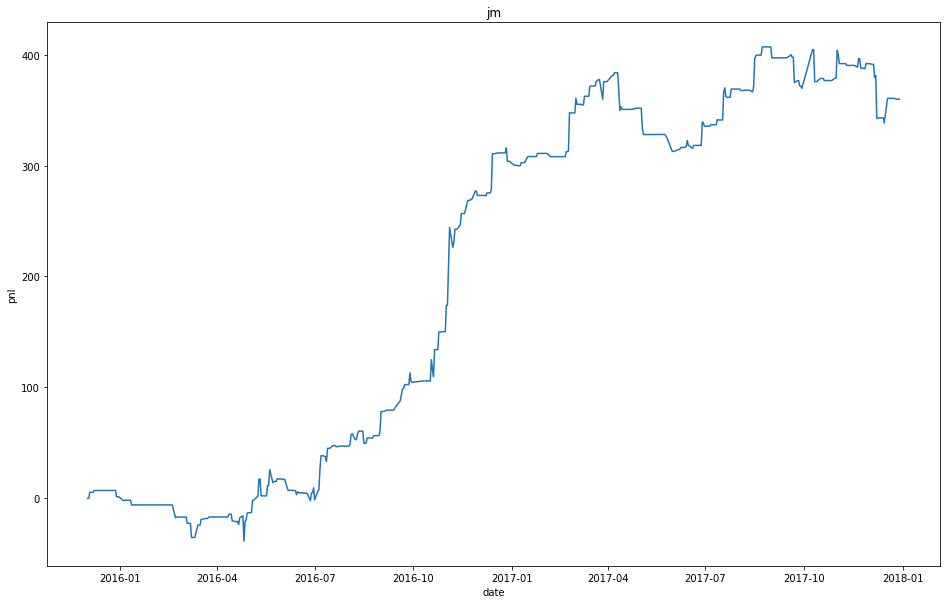

In [91]:
i = 0
train_trade_stat = load(HEAD_PATH+"/train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[train_sample], good_pnl.cumsum());


In [52]:
%%time
signal_name = "trade.imb.4096"
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    test_trade_stat[product] = trade_stat
# Wall time: 6min 50s

Wall time: 6min 50s


In [53]:
save(test_trade_stat, HEAD_PATH+"/test_trade_stat.pkl")

- now we get the out-of-sample test result

rb train sharpe  1.7996339395302534 test sharpe  0.6569154099294877
hc train sharpe  1.0270632992801167 test sharpe  0.3897758964643211
i train sharpe  0.7765742416870032 test sharpe  1.2700887599104178
j train sharpe  0.5548498046535456 test sharpe  1.2974683818731747
jm train sharpe  1.7034760802688553 test sharpe  0.5342180217057451


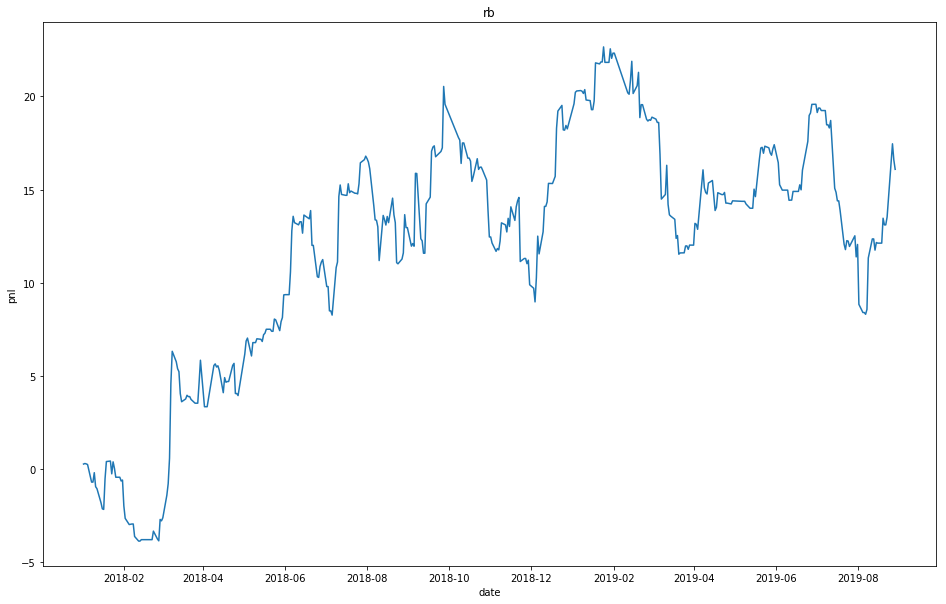

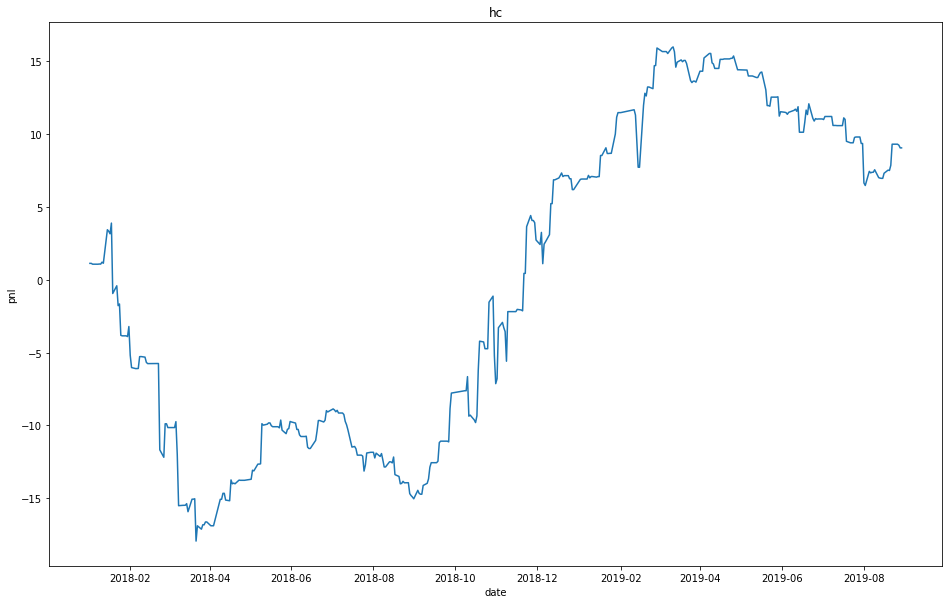

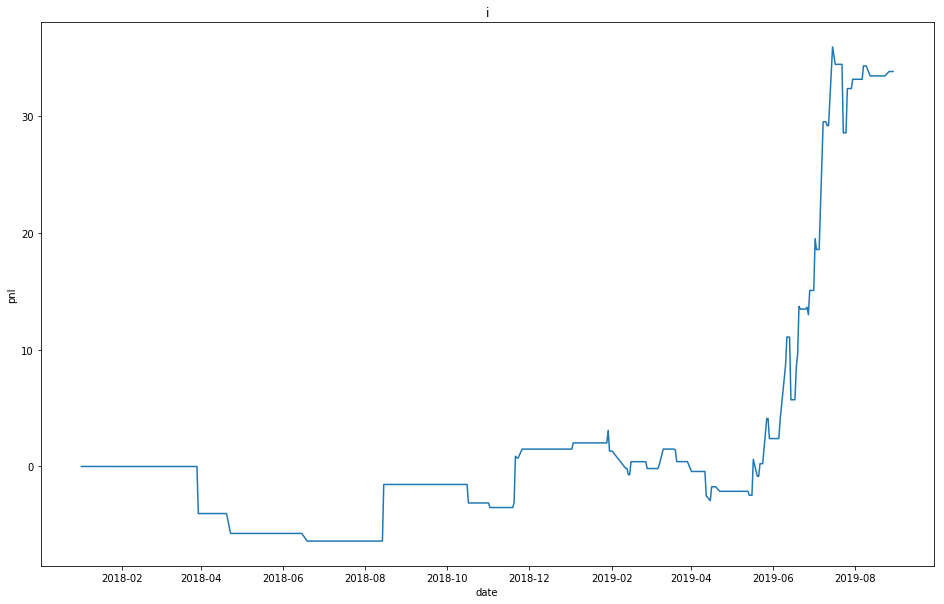

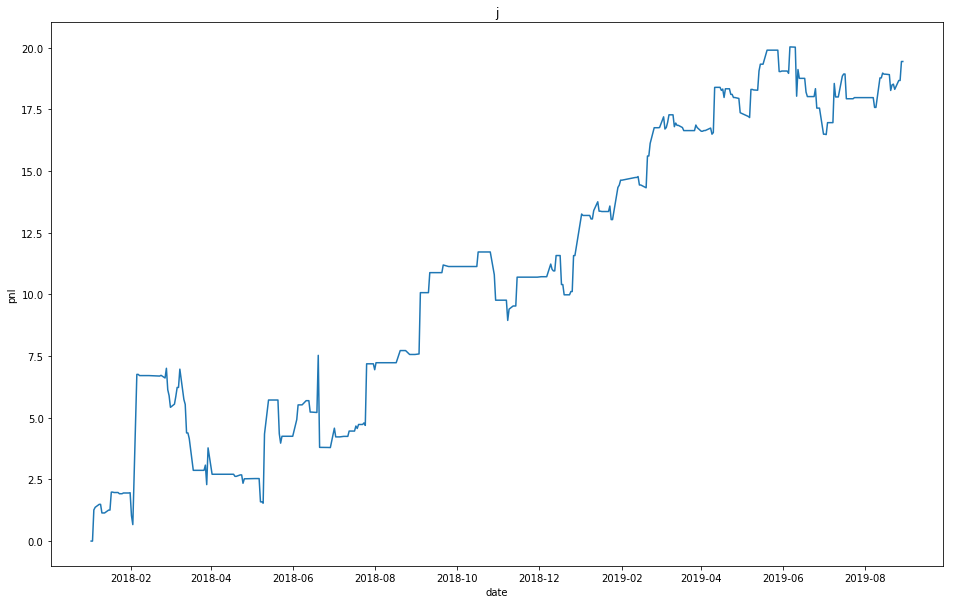

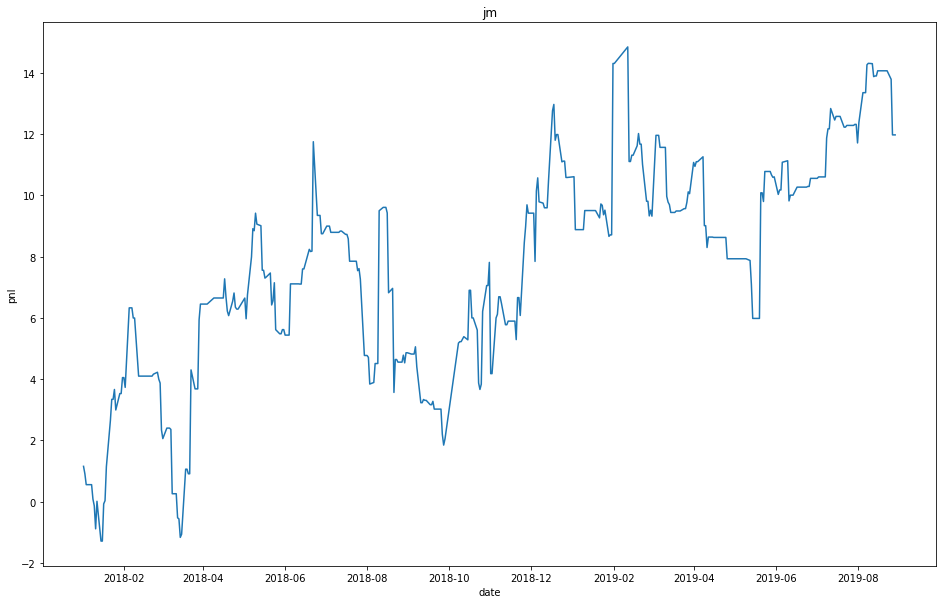

In [67]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    train_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[test_sample], test_pnl.cumsum());
    
# rb train sharpe  1.7996339395302545 test sharpe  0.6569154099294877
# hc train sharpe  1.0270632992801174 test sharpe  0.3897758964643211
# i train sharpe  0.7765742416869972 test sharpe  1.2700887599104178
# j train sharpe  0.5548498046535438 test sharpe  1.2974683818731747
# jm train sharpe  1.7034760802688649 test sharpe  0.5342180217057451


- now calculate the result of test samples

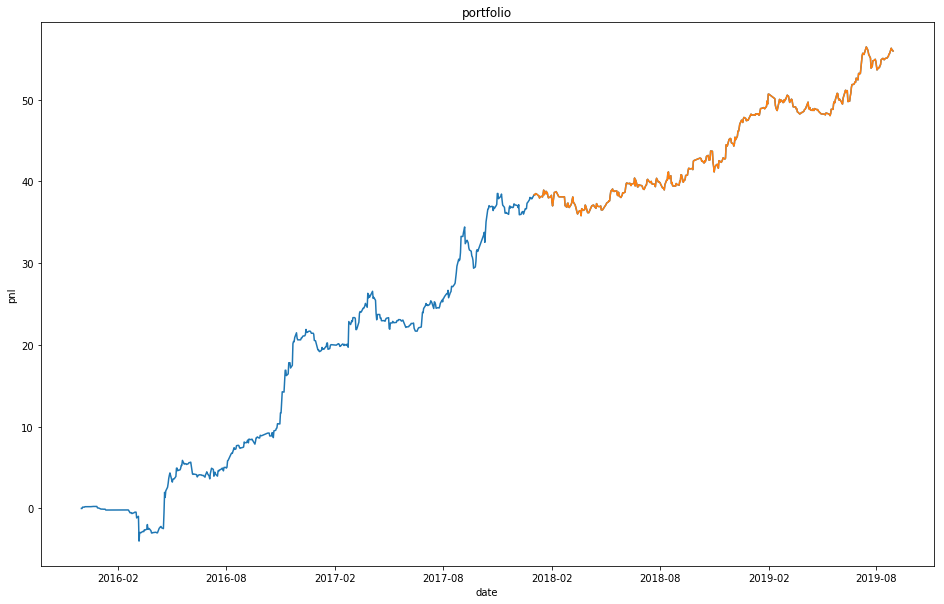

In [87]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    

In [89]:
print(sharpe(train_portfolio), sharpe(test_portfolio))
## 2.3382051170620364 1.7637671132189927

2.3382051170620364 1.7637671132189927


- Homework:
- you can try using total.trade.imb.4096 to test again
- you can try using 1024/2048 to repeat this process and compare the result
- you can change the atr threshold of 20 to other values
- you can change the split of train/test samples
- you can try using reverse=1 and -1